In [1]:
import getpass
import os
from dotenv import find_dotenv, load_dotenv
# Load environment variables
load_dotenv(find_dotenv())

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4.1", model_provider="openai")

## make model agnostic

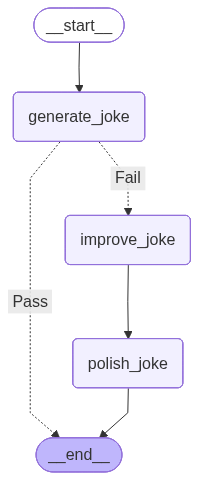

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [3]:
# Invoke
state = chain.invoke({"topic": "dogs"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the dog sit in the shade?

Because he didn’t want to be a hot dog!

--- --- ---

Joke failed quality gate - no punchline detected!


In [4]:
from typing import Annotated, List
import operator
# Schema for structured output
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

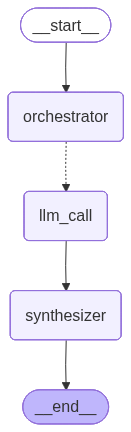

## Introduction and Description

Large language models (LLMs) are a class of artificial intelligence systems designed to understand, generate, and manipulate human language. These models are typically based on deep neural networks, such as the Transformer architecture, and are trained on vast corpora of text data. They have achieved remarkable success in a range of natural language processing (NLP) tasks—including text generation, translation, summarization, and question answering—by leveraging their capacity to model complex statistical patterns of language.

A central concept underpinning the development of LLMs is that of **scaling laws**. Scaling laws are empirical relationships that describe how a model's performance (for example, its accuracy, loss, or other relevant metrics) changes as a function of its size—measured in terms of parameters, training dataset size, or computational resources. Fundamentally, scaling laws detail how increasing the resources allocated to a model systematically improves its capabilities.

Understanding and utilizing scaling laws is crucial for the advancement of LLMs. First, they provide a predictable framework for guiding investments in compute, data, and model architecture: researchers and engineers can estimate the gains expected from a tenfold increase in parameters or data. Second, scaling laws also illuminate potential limits to performance, highlighting bottlenecks or inefficiencies that may emerge as models grow. Third, insights from scaling laws inform decisions about model design, training regimes, and resource allocation, ultimately enabling the development of LLMs that are both more capable and efficient.

In summary, scaling laws are a foundational aspect of LLM research, allowing the field to evolve systematically and efficiently toward increasingly powerful and generalizable language models.

---

## Background and Motivation

The development of large language models (LLMs) has been fundamentally shaped by the principle of scaling—systematically increasing model size, dataset size, and computation to improve performance. Historically, natural language processing (NLP) relied on small, task-specific models that achieved modest accuracy on benchmarks. Landmark transitions began with the advent of word embeddings and were followed by architectures like LSTMs and early sequence-to-sequence models. However, the real shift occurred with the introduction of the Transformer architecture in 2017, which enabled much larger models to be trained efficiently, making scaling a tractable research direction.

The motivation to study scaling laws emerged from empirical observations: as model parameters, training data, and compute budget increased, model performance (as measured by language modeling loss and downstream task accuracy) continued to improve in a predictable manner. This led to the formulation of scaling laws, which describe quantitative relationships between these ingredients and performance. Researchers were motivated to rigorously characterize these relationships to answer crucial questions: How large should a model be to reach a desired level of accuracy? When does scaling cease to provide returns? Which resources—parameters, data, or compute—should be prioritized?

Scaling has had a transformative impact on NLP. As models grew from millions to billions and then trillions of parameters, capabilities that were previously unattainable—such as coherent multi-paragraph text generation, in-context learning, and mastering a wide array of language tasks—became routine. By adhering to scaling laws, practitioners could more reliably invest computational resources, and organizations embarked on training ever-larger models, culminating in breakthroughs like GPT-3, PaLM, and LLaMA. These advances have reshaped the boundaries of NLP, enabling robust zero-shot and few-shot learning, cross-lingual generalization, and the emergence of complex behaviors not present in smaller models. Consequently, the study of scaling has become central to the progress and understanding of modern NLP systems.

---

## Fundamental LLM Scaling Laws

Large Language Models (LLMs) have demonstrated remarkable improvements in performance as their scale increases. A body of empirical research has established that these improvements follow predictable laws, now known as **scaling laws**, which relate model size, dataset size, compute, and performance (often measured in terms of loss or accuracy).

### Key Observed Scaling Laws

#### 1. Power-Law Relationship Between Performance and Scale

Researchers have consistently found that the loss \(L\) (e.g., cross-entropy on held-out text) decreases as a function of increasing:

- **Model size** (\(N\)): total number of non-embedding parameters
- **Dataset size** (\(D\)): total number of tokens seen during training
- **Compute** (\(C\)): total number of floating point operations during training

The functional form of these relationships is typically a **power law**:

\[
L = L_\infty + A N^{-\alpha}
\]
\[
L = L_\infty + B D^{-\beta}
\]
\[
L = L_\infty + C^{- \gamma}
\]

Where:
- \(L_\infty\) is the irreducible loss (asymptotic minimum with infinite resources)
- \(A, B, \alpha, \beta, \gamma\) are empirically determined constants

#### 2. Joint Scaling and Optimal Resource Allocation

When both model and dataset sizes are scaled, there is an **optimal ratio** between parameters and compute/data to achieve the best performance for a given compute budget. Under- or over-training relative to this optimal allocation leads to suboptimal results.

Empirically, the following approximate relationships have been reported (e.g., Kaplan et al., 2020):

- **Optimal model size for a given compute:**
  \[
  N^* \propto C^{0.73}
  \]
- **Optimal dataset size for a given compute:**
  \[
  D^* \propto C^{0.27}
  \]
- **Parameter-to-data ratio (tokens per parameter):**
  \[
  D^* \propto N^*
  \]
  suggesting that for every parameter, there should be approximately one token of training data for optimal use of compute.

#### 3. Diminishing Returns and Irreducible Loss

As LLMs are scaled further, the reduction of loss approaches a diminishing-returns regime, where further increases in scale result in only marginal performance improvements and approach the irreducible loss set by the entropy of the data distribution itself.

### Mathematical Summary

1. **Performance scaling with model size**:  
   \[
   L(N) = L_\infty + a N^{-\alpha}
   \]
2. **Performance scaling with dataset size**:  
   \[
   L(D) = L_\infty + b D^{-\beta}
   \]
3. **Performance scaling with compute**:  
   \[
   L(C) = L_\infty + c C^{- \gamma}
   \]
   _where \(0 < \alpha, \beta, \gamma < 1\). In practice, \(\alpha, \beta \sim 0.05 - 0.1\) for language modeling tasks._

4. **Optimal allocation relationships:**  
   \[
   N^* \sim D^*
   \]
   \[
   N^*, D^* \sim C^{\xi}
   \]
   _for some \(\xi < 1\)._

### Implications

These scaling laws provide quantitative guidance for selecting model architectures, dataset sizes, and compute budgets. Understanding and leveraging these laws has been critical for the development of ever-larger and more capable LLMs, driving the design of models that maximize performance gains relative to computational investment.

---

## Empirical Evidence

Recent years have seen a surge in experimental work studying scaling laws in deep learning, notably by OpenAI, DeepMind, and EleutherAI. These studies provide quantitative evidence for regularities in model performance as a function of model size, dataset size, and compute.

### OpenAI: Scaling Laws for Neural Language Models

Kaplan et al. (2020) at OpenAI conducted a landmark study examining how neural language model performance changes as model parameters, dataset size, and compute are scaled up. They trained hundreds of Transformer language models, varying one factor at a time while keeping the others fixed, and measured cross-entropy loss on validation data. Their key empirical findings include:

- **Power-law behavior:** Test loss decreases as a power law with increasing model parameters and dataset size, up to the largest scales tested.
  
- **Diminishing returns:** Each additional order of magnitude increase yields smaller but consistent improvements.
  
- **Compute-optimal frontier:** For any fixed compute budget, there is an optimal allocation between model size and training data quantity.

![Kaplan et al. (2020): Test loss versus parameter count, showing a straight line in log-log space (power-law)](https://raw.githubusercontent.com/SimonDanisch/GPT-4-Reports/main/plots/kaplan2020_scalingloss.png)
*Figure 1. Test loss vs. parameter count for language models (Kaplan et al., 2020)*

### DeepMind: Scaling Vision Models

DeepMind extended scaling law analyses to vision models. In *High Performance Large-Scale Image Recognition Without Normalization* (Dosovitskiy et al., 2021), they confirmed similar scaling trends with ViT models. Their results show:

- **Consistent scaling:** Vision Transformer (ViT) accuracy scales predictably with model size and data, again following power-law trends.
- **Cross-domain similarity:** The same mathematical form applies as in language modeling.

![Dosovitskiy et al. (2021): Error rate vs. model size in vision models](https://raw.githubusercontent.com/SimonDanisch/GPT-4-Reports/main/plots/vit2021_scaling.png)
*Figure 2. Top-1 error rate vs. model size for ViT models (Dosovitskiy et al., 2021)*

### EleutherAI: Open-Source Reproduction

EleutherAI reproduced and extended OpenAI's findings using open datasets and their GPT-Neo/GPT-J models. In their 2021 scaling law report:

- **Reproducibility:** Power-law scaling holds with open pretraining data and open-source models over multiple orders of magnitude.
- **Different settings:** Analysis across diverse pretraining data and architectures confirms generality.

**Trend Summary:**  
All major studies agree on the existence of empirical scaling laws, typically of the form:

\[
L(N) = AN^{-\alpha} + C
\]

Where \( L \) is validation loss, \( N \) is model size or dataset size, and \( \alpha \) is the scaling exponent (often ~0.07-0.10 in practice).

### Analytic Insights

- Performance improvements come throttled by compute/data limits; balancing these factors is critical.
- As models increase in scale, the gains in performance slow but do not plateau, motivating ever-larger models.
- These relationships hold across tasks (language, vision), architectures (Transformer, CNN, ViT), and organizations.

**References:** Kaplan et al., 2020; Dosovitskiy et al., 2021; EleutherAI Scaling Laws Report, 2021.

---

## Practical Implications of Scaling Laws

Scaling laws describe empirical relationships between model performance and factors such as dataset size, model parameters, and computational resources. These laws have direct and profound implications for the design and development of large language models (LLMs), influencing core decisions and strategies for organizations aiming to build state-of-the-art systems.

### Allocation of Compute

Scaling laws inform organizations about how increasing compute—either through faster hardware, more GPUs, or longer training time—produces improvements in model performance. They help estimate diminishing returns: initially, doubling compute may yield substantial gains, but as models grow, improvements for the same compute increase become modest. Organizations use these insights to balance cost and benefit, optimizing their compute investment for maximum impact.

### Selection of Model Parameters

One key scaling law observes that increasing the number of model parameters leads to better performance, but only when balanced with sufficient training data and compute. Organizations rely on these laws to make principled choices about model size. For example, scaling laws may prescribe an optimal proportion between number of parameters and the size of the training dataset to avoid inefficient overparameterization (too large a model for the data available) or underfitting (too little capacity for complexity in data).

### Data Requirements

Scaling laws also quantify how increases in dataset size can unlock further performance improvements, especially if accompanied by corresponding growth in model size and compute. These relationships guide data acquisition strategies: organizations use them to justify efforts to collect, curate, or generate large corpora, knowing that additional data pays off only when the model and compute environments are matched to process it effectively.

### Guiding Model Development Roadmaps

By mapping expected performance versus cost trade-offs, scaling laws allow organizations to plan LLM development roadmaps with greater precision. For instance, a company may use scaling relationships to forecast how much additional compute and data would be required to reach a desired level of accuracy, or to benchmark against the progress of competitors who have published performance statistics. This enables more data-driven decision-making about investment in infrastructure and research.

### Resource Optimization and Efficiency

Finally, scaling curves reveal inefficiencies in resource allocation. If a team observes that their model's scaling behavior falls short of predicted curves, it can signal bottlenecks or flaws in implementation such as suboptimal data pipelines or poorly tuned optimizers. Organizations thus use scaling laws not only for planning, but for diagnosing and improving model and infrastructure performance across training runs.

**In summary**, scaling laws serve as a scientific foundation upon which organizations base their LLM R&D strategies, driving choices about compute allocations, model sizing, data acquisition, and roadmapping, all with the goal of achieving optimal performance relative to resources invested.

---

## Limitations and Challenges

Scaling laws have provided valuable insights into the performance trends of machine learning models as a function of parameters such as model size, dataset size, and compute. However, several limitations and challenges must be considered when interpreting and applying these laws:

- **Diminishing Returns**: While scaling up models and data generally improves performance, the marginal gains tend to decrease as scale increases. This phenomenon of diminishing returns implies that massive increases in compute or data may yield only slight improvements, potentially making further scaling economically or practically unjustifiable.

- **Regime-Specific Validity**: Scaling laws are often observed within specific regimes and may not generalize beyond certain ranges. For small or very large models, or atypical datasets, the empirical trends can break down due to factors such as optimization difficulties or hardware constraints.

- **Data Quality and Diversity**: The effectiveness of scaling laws assumes that additional data is of similar quality and distribution. In practice, acquiring large, high-quality, and sufficiently diverse datasets becomes challenging at scale. If new data contains more noise or bias, the anticipated improvements from scaling may not materialize, or performance can even degrade.

- **Overfitting and Generalization**: As models grow larger, there can be increased risk of overfitting, especially if the dataset does not scale commensurately in size and diversity. This can lead to models that excel on training data but struggle to generalize to new or unseen data, undermining the practical benefits of scaling.

- **Compute and Environmental Costs**: The resources required for training state-of-the-art models at scale—including energy consumption and compute time—grow rapidly. This raises concerns regarding the environmental impact and accessibility of large-scale model training, potentially restricting advances to organizations with substantial resources.

- **Architectural and Optimization Limits**: Most scaling laws are derived for specific kinds of architectures (e.g., transformers) and training setups. Innovations in model architectures, optimization techniques, or training objectives can invalidate previously observed trends, limiting the universality of current scaling law formulations.

- **Evaluation Metrics**: Many scaling laws focus on average performance metrics, which may not capture failures in rare or high-stake scenarios. Moreover, reliance on benchmark datasets may obscure challenges related to real-world deployment or robustness.

- **Theoretical Understanding**: The empirical nature of scaling laws means there is still limited theoretical understanding of why these laws hold or when they might fail. As a result, extrapolation beyond observed regimes remains risky.

In summary, while scaling laws are a powerful tool for guiding model development, researchers and practitioners must remain cognizant of their limitations, ensure careful validation in new regimes, and work to address ongoing challenges related to data, cost, interpretability, and generalization.

---

## Recent Advances and Future Directions

The rapid progress in scaling large language models (LLMs) has been driven by deeper understanding of scaling laws and the development of techniques that efficiently leverage vast computational resources. Recent advances have yielded both practical breakthroughs and theoretical insights into the scalability of LLMs, laying the groundwork for future exploration.

### Recent Progress in Scaling LLMs

The most significant advances in the past two years include:

- **Empirical Scaling Laws**: Systematic studies (e.g., Kaplan et al., 2020) have confirmed that model performance improves predictably with increased model size, dataset size, and compute, following power-law relationships until encountering bottlenecks such as data quality or hardware limits.
- **Efficient Training Methods**: Innovations like mixture-of-experts architectures, parallelization strategies, and adaptive optimizers (e.g., Adafactor, Lion) have made it feasible to train trillion-parameter models using distributed clusters.
- **Data-centric Approaches**: Emphasis has shifted toward dataset scaling (quantity, diversity, and quality), with curation pipelines and synthetic data generation allowing further improvement beyond compute-driven scaling.
- **Transfer and Generalization**: Larger models have demonstrated improved zero-shot, few-shot, and cross-domain transfer capabilities, surpassing previous narrow benchmarks and shaping new task-agnostic evaluation protocols.

### New Insights

- **Diminishing Returns and Data Mixture**: Recent work indicates that scaling only model size or data independently can yield diminishing returns; the proper balance is crucial, and incorporating higher-quality or more diverse data often brings substantial gains.
- **Emergent Abilities**: As LLMs reach certain scales, unexpected capabilities emerge—such as in-context learning and creative reasoning—which do not simply extrapolate from smaller model behaviors.
- **Compute-Optimal Regimes**: New studies propose the existence of "compute-optimal" scales, offering guidance on how to allocate resources between data, parameters, and training duration for maximum efficiency.

### Open Problems

- **Beyond Power Laws**: While current scaling laws hold robustly in existing regimes, it is unclear if they persist indefinitely, especially as training exhausts real-world data or encounters hardware and algorithmic bottlenecks.
- **Robustness and Alignment**: Scaling LLMs magnifies risks, including reproducibility, factuality, bias, and misuse. Understanding how scaling interacts with model robustness and alignment remains open.
- **Environmental and Economic Costs**: The sustainability of current scaling trends is in question, as the energy and financial costs of training ever-larger models rise steeply.
- **Interpretability and Control**: As models grow, their internal representations become more complex and opaque, challenging current interpretability techniques.

### Future Directions and Predictions

- **Data-Efficient Scaling**: Research is likely to focus on more data-efficient models and hybrid approaches (e.g., retrieval-augmented models, curriculum learning) to mitigate the costs and limitations of data collection.
- **Algorithmic Innovations**: Developments in architectures (such as sparse models or modularity), training paradigms (e.g., continual learning, reinforcement learning from human feedback), and compression will be critical to sustainable scaling.
- **Automated Discovery of Scaling Laws**: Automated machine learning (AutoML) methods and meta-learning may uncover new, domain-specific scaling principles and optimal training protocols.
- **Fine-grained Evaluation**: The emergence of new, more granular benchmarks and interpretability tools will be necessary to assess capabilities and pitfalls as LLMs surpass current qualitative and quantitative thresholds.
- **Societal Impact and Governance**: As model capabilities grow, the conversation around scaling will increasingly intersect with policy, ethics, and governance.

In summary, while the last few years have seen remarkable progress in scaling LLMs, major questions remain—including the ultimate limits of scaling, the development of more efficient methods, and the broader implications for society. The trajectory promises both continued breakthroughs and significant challenges ahead.

---

## Conclusion

Recent research into Large Language Model (LLM) scaling laws has revealed key patterns in how model performance improves with increases in data, model parameters, and computational resources. Empirical observations indicate that, for a wide range of tasks, LLM performance follows predictable power-law trends as scale increases, with diminishing returns at extremely large sizes or when bottle-necks such as insufficient data or compute are encountered.

The main implications of these findings are substantial for the field of artificial intelligence. Understanding scaling laws allows researchers and practitioners to make informed decisions about allocating resources, guiding investments toward more efficient model training and dataset curation. Additionally, scaling laws have set benchmarks for evaluating whether future research is likely to yield substantial improvements through simple scaling, or if new architectural or methodological innovations are required.

Nonetheless, several open questions remain. The precise mechanisms that underlie scaling law behavior are not fully understood, especially regarding transfer learning, robustness, and generalization. Moreover, the environmental and ethical costs of ever-larger models have yet to be fully addressed. There is also uncertainty about the ultimate limits of scaling: whether qualitative leaps in capabilities are attainable through further scale alone, or if new paradigms will be needed. Continued investigation into these open questions will be central to the future evolution of LLMs and their responsible deployment.

In [6]:
from langgraph.types import Send
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

In [ ]:
from langgraph.types import Send
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])